# Download data


In [1]:
!git clone https://github.com/anminhhung/vehicle_data

Cloning into 'vehicle_data'...
remote: Enumerating objects: 19471, done.
remote: Total 19471 (delta 0), reused 0 (delta 0), pack-reused 19471
Receiving objects: 100% (19471/19471), 1.95 GiB | 44.36 MiB/s, done.
Updating files: 100% (19510/19510), done.


# Setup Detectron2

In [2]:
!git clone https://github.com/facebookresearch/detectron2

Cloning into 'detectron2'...
remote: Enumerating objects: 15124, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 15124 (delta 75), reused 92 (delta 50), pack-reused 14979
Receiving objects: 100% (15124/15124), 6.18 MiB | 14.03 MiB/s, done.
Resolving deltas: 100% (10937/10937), done.


In [3]:
!python -m pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp310-cp310-linux_x86_64.whl size=44090 sha256=4529edf06394bd0d067f20ca294ce2db9080e2fb17d7db1fc984f291223e65b2
  Stored in directory: /root/.cache/pip/wheels/70/83/31/975b737609aba39a4099d471d5684141c1fdc3404f97e7f68a
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
flax 0.6.11 requires PyYAML>=5.4.1, but you have pyyaml 5.1 which is incompatible.
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-kmo7v3rm
  R

# Import lib

In [4]:
import os
import cv2
import json
import random
import itertools
import torch
import copy
import numpy as np

import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer,  DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.structures import BoxMode
from detectron2.data import detection_utils
import detectron2.data.transforms as T

from google.colab.patches import cv2_imshow

# Convert yolo -> json (detectron format)

In [5]:
def get_data_dicts_mrcnn(img_dir):
    anno_files = [f for f in os.listdir(img_dir) if f.split(".")[-1] != 'txt']
    # print("anno_files: ", anno_files)
    classes = ['0', '1', '2', '3', '4']

    dataset_dicts = []
    count = 0
    fail_cnt = 0
    for image_id, filename in enumerate(anno_files):
      try:
        record = {}
        img_path = os.path.join(img_dir, filename)
        # print("img_path: ", img_path)
        height, width = cv2.imread(img_path).shape[:2]

        record["file_name"] = img_path
        record["image_id"] = image_id
        record["height"] = height
        record["width"] = width

        txt_path = filename.split(".")[0] + '.txt'
        annotations = open(os.path.join(img_dir, txt_path), 'r')
        objs = []
        for line in annotations:
          line = line.rstrip('\n')
          class_id, x_center, y_center, w, h = line.split()[:]
          w = int(float(w) * width)
          h = int(float(h) * height)
          xmin = int((float(x_center) * width) - w/2)
          ymin = int((float(y_center) * height) - h/2)
          xmax = xmin + w
          ymax = ymin + h

          px = [xmin, xmax, xmax, xmin]
          py = [ymin, ymin, ymax, ymax]

          poly = [(x, y) for x, y in zip(px, py)]
          poly = list(itertools.chain.from_iterable(poly))

          obj = {
                'bbox': [xmin, ymin, xmax, ymax],
                'bbox_mode': BoxMode.XYXY_ABS,
                'segmentation': [poly],
                'category_id': int(class_id),
                "iscrowd": 0
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
        count += 1
        # print(count)
      except:
        fail_cnt += 1
        with open("fail_log.txt", "a+") as f:
          f.write("path image failed: {}\n".format(img_path))

    # print("fail_cnt: ", fail_cnt)
    return dataset_dicts

In [6]:
train_dicts = get_data_dicts_mrcnn('vehicle_data/train')
val_dicts = get_data_dicts_mrcnn('vehicle_data/val')

# write and save data
with open('train_dicts_rcnn.json', 'w') as fp:
    json.dump(train_dicts, fp)

with open('val_dicts_rcnn.json', 'w') as fp:
    json.dump(val_dicts, fp)

# Load json data, trainer

In [7]:
# Load json data
with open('train_dicts_rcnn.json', 'r') as fp:
    val_dicts = json.load(fp)

with open('val_dicts_rcnn.json', 'r') as fp:
    train_dicts = json.load(fp)

In [8]:
for i in range(len(val_dicts)):
  for j in range(len(val_dicts[i]["annotations"])):
      val_dicts[i]["annotations"][j]['bbox_mode'] = BoxMode.XYXY_ABS

for i in range(len(train_dicts)):
  for j in range(len(train_dicts[i]["annotations"])):
      train_dicts[i]["annotations"][j]['bbox_mode'] = BoxMode.XYXY_ABS

In [9]:
classes = ['0', '1', '2', '3', '4']
data = [train_dicts, val_dicts]

for index, d in enumerate(["train", "val"]):
  DatasetCatalog.register("vehicle_data/" + d, lambda index=index: data[index])
  MetadataCatalog.get("vehicle_data/" + d).set(thing_classes=classes)

vehicle_metadata = MetadataCatalog.get("vehicle_data/train")

In [10]:
# Without Augmentation
class CustomTrainer(DefaultTrainer):
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("mask_rcnn_R_101_FPN_3x_new_train", exist_ok=True) # name dir
        output_folder = "mask_rcnn_R_101_FPN_3x_new_train"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [11]:
def custom_mapper(dataset_dict, size = (800,800), flip_prob = 0, min_brightness = 0.5, max_brightness = 1.5, \
                min_contrast = 0.5, max_contrast = 1.5, min_saturation = 0.5, max_saturation = 1.5):
    # Implement a mapper, similar to the default DatasetMapper, but with your own customizations
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = detection_utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
                    T.Resize(size),
                    T.RandomBrightness(min_brightness, max_brightness),
                    T.RandomContrast(min_contrast, max_contrast),
                    T.RandomSaturation(min_saturation, max_saturation),

                    T.RandomFlip(prob=flip_prob, horizontal=False, vertical=True),
                    T.RandomFlip(prob=flip_prob, horizontal=True, vertical=False),
                ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        detection_utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = detection_utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = detection_utils.filter_empty_instances(instances)
    return dataset_dict

# Training with augmentation
class AugmentTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):

        if output_folder is None:
            os.makedirs("Evaluate_dir", exist_ok=True)
            output_folder = "Evaluate_dir"

        return COCOEvaluator(dataset_name, cfg, False, output_folder)

# Visualize data

In [12]:
import random
import matplotlib.pyplot as plt

# dataset_dicts = get_license_plate_dicts('detectron2/datasets/license_plate_dataset/val')
for d in random.sample(val_dicts, 10):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=vehicle_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Train

In [13]:
cfg = get_cfg()
cfg.merge_from_file("./detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("vehicle_data/train",)
cfg.DATASETS.TEST = ("vehicle_data/val",)   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 4

#https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
# cfg.MODEL.WEIGHTS = "mask_rcnn_R_101_FPN_3x_model_new_train/model_final.pth" # load saved model
# cfg.MODEL.WEIGHTS = "" # without transfer learning

cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.00001
cfg.SOLVER.MAX_ITER = 500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7
cfg.OUTPUT_DIR = "./mask_rcnn_R_101_FPN_3x_model_new_train"

cfg.TEST.EVAL_PERIOD = 500 # eval for each 500 iters

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/29 05:37:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_a3ec72.pkl: 254MB [00:02, 122MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[06/29 05:37:58 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/29 05:38:58 d2.utils.events]:  eta: 0:22:11  iter: 19  total_loss: 3.896  loss_cls: 2.214  loss_box_reg: 0.8201  loss_mask: 0.6919  loss_rpn_cls: 0.08524  loss_rpn_loc: 0.06763    time: 2.7745  last_time: 2.8348  data_time: 0.0631  last_data_time: 0.0317   lr: 3.8962e-07  max_mem: 13879M
[06/29 05:40:02 d2.utils.events]:  eta: 0:21:38  iter: 39  total_loss: 3.887  loss_cls: 2.205  loss_box_reg: 0.846  loss_mask: 0.6918  loss_rpn_cls: 0.08988  loss_rpn_loc: 0.05495    time: 2.9168  last_time: 3.2455  data_time: 0.0320  last_data_time: 0.0270   lr: 7.8922e-07  max_mem: 13879M
[06/29 05:41:06 d2.utils.events]:  eta: 0:22:52  iter: 59  total_loss: 3.861  loss_cls: 2.19  loss_box_reg: 0.8452  loss_mask: 0.6913  loss_rpn_cls: 0.07046  loss_rpn_loc: 0.06198    time: 3.0176  last_time: 2.8826  data_time: 0.0353  last_data_time: 0.0349   lr: 1.1888e-06  max_mem: 13879M
[06/29 05:42:10 d2.utils.events]:  eta: 0:22:19  iter: 79  total_loss: 3.831  loss_cls: 2.164  loss_box_reg: 0.8438  loss_m

# Predict

[06/29 07:00:17 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/mask_rcnn_R_101_FPN_3x_model_new_train/model_final.pth ...


roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


{'instances': Instances(num_instances=100, image_height=720, image_width=1280, fields=[pred_boxes: Boxes(tensor([[ 359.0567,  211.4905,  435.5783,  292.5190],
        [ 798.9562,  129.8069,  864.3126,  188.5484],
        [ 189.6867,  121.5907,  204.1255,  131.6680],
        [ 223.6281,  124.4273,  235.5338,  140.7513],
        [ 133.7158,  134.4639,  143.8532,  150.1686],
        [ 218.4311,  127.2802,  230.2070,  140.7370],
        [1032.5687,  130.8926, 1073.2096,  202.4096],
        [1014.9758,  611.7391, 1143.4114,  720.0000],
        [ 658.5512,  195.5356,  713.6237,  244.6700],
        [ 188.5608,  123.4763,  200.5633,  136.3114],
        [ 137.6497,  136.5200,  147.0718,  152.3789],
        [ 252.4307,  131.1722,  303.0121,  176.7043],
        [ 321.7408,  201.8018,  457.0002,  302.2139],
        [ 266.0398,  138.0683,  293.5516,  161.0461],
        [ 226.5637,  129.1415,  239.5325,  144.4024],
        [ 981.9431,  156.8864,  989.9448,  170.2690],
        [ 236.0678,  122.2588, 

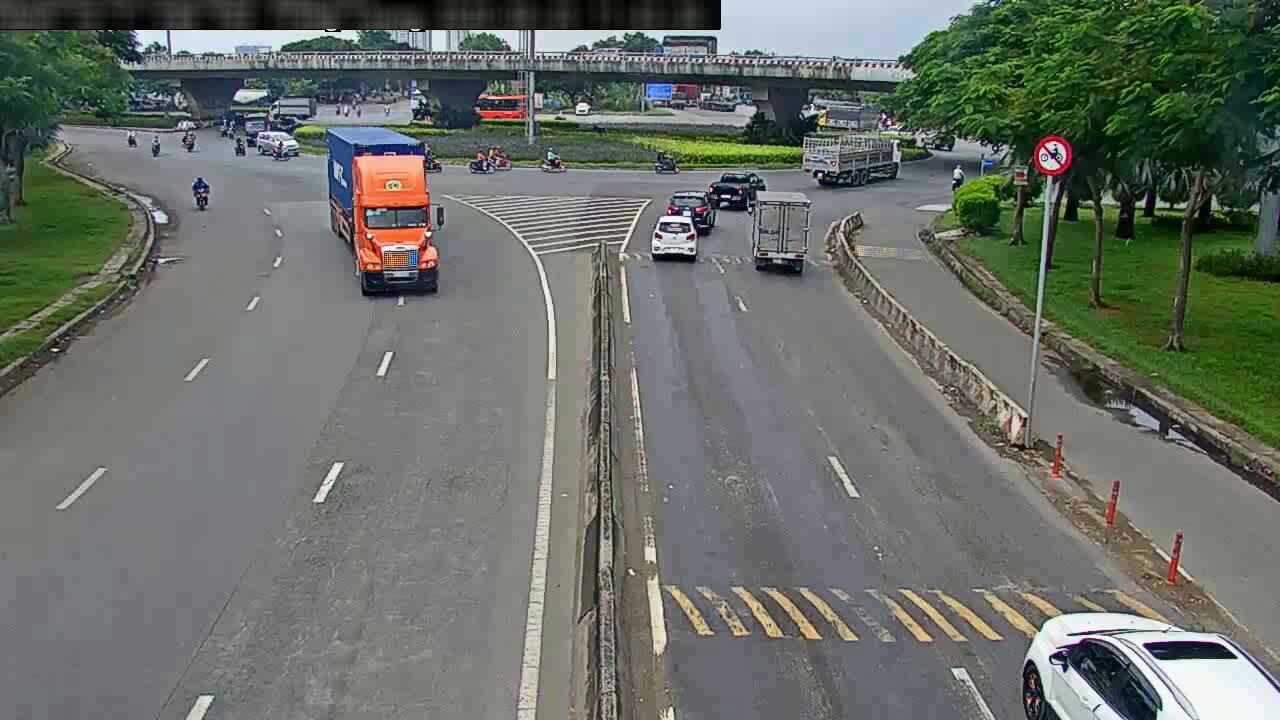

In [16]:
import os
import cv2
import json
import time
import random
import itertools
import numpy as np

from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, evaluator
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.structures import BoxMode
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

import json

def predict (path_weigths, path_config, confidence_threshold, num_of_class, path_img


             ):
  cfg = get_cfg()
  cfg.merge_from_file(path_config)
  cfg.MODEL.WEIGHTS = path_weigths

  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = confidence_threshold
  cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 8
  cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_of_class
  predictor = DefaultPredictor(cfg)
  im = cv2.imread(path_img)
  outputs = predictor(im)

  boxes = outputs["instances"].pred_boxes
  scores = outputs["instances"].scores
  classes = outputs["instances"].pred_classes

  list_bbox = []
  for bbox in boxes:
    list_tmp = []
    for ele in bbox:
      list_tmp.append(int(ele))

    list_bbox.append(list_tmp)

  list_classes = []
  for my_cls in classes:
    list_classes.append(classes_raw[my_cls])

  return outputs, list_bbox, scores, list_classes

#Đầu vào detect = output của hàm predict, frame = original image của mình, classs = tên class để visualize
def visualize (out, frame, classs):
  boxes = out['instances'].pred_boxes
  scores = out['instances'].scores
  classes = out['instances'].pred_classes
  for i in range (len(classes)):
    if (scores[i] > 0.4):
      for j in boxes[i]:
        start = (int (j[0]), int (j[1]))
        end = (int (j[2]), int (j[3]))
        print (start)
        print (end)
        width =  end[0] - start[0]
        height = end[1] - start[1]
        print ('width:', width)
        print ('height:', height)
        print('class:', int (classes[i]))
        print('score:', float (scores[i]))
        print ('---------------------', start, end, scores[i], classes[i])
      color = int (classes[i])
      print (classes[i])

      cv2.rectangle(frame, start, end, (random.randint(0,255),random.randint(0,255),255), 1)
      cv2.putText(frame, str (classs[color]),start, cv2.FONT_HERSHEY_PLAIN, 1, (random.randint(0,255),random.randint(0,255),255), 2)
  return frame


path_weigth = '/content/mask_rcnn_R_101_FPN_3x_model_new_train/model_final.pth'
path_config = './detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml'
confidences_threshold = 0.1
num_of_class = 5
path_img = 'vehicle_data/val/cam_01_0.jpg'
classes_raw = ['0', '1', '2', '3', '4']

outputs, boxes, scores, classes = predict(path_weigth, path_config, confidences_threshold, num_of_class, path_img)
print(outputs)
_frame = cv2.imread(path_img)
frame = visualize (outputs, _frame, classes )
cv2.imwrite("frame.jpg", frame)
cv2_imshow(frame)
